In [1]:
# add number of delays per day over full dataset

In [3]:
import mca
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from datetime import datetime, timedelta
import os
import html
import re
from dateutil.parser import parse
import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV, StratifiedKFold

## Data loading 

In [5]:
df_lines = pd.read_csv("./Online_Data/referentiel-des-lignes.csv", sep=';')
stops_data = pd.read_csv("./Online_Data/arrets.csv", sep=';')

trafic2023_ratio = pd.read_csv("./Online_Data/validations-1er-semestre.csv", sep=';')
trafic2023_raw = pd.read_csv("./Online_Data/validations-reseau.csv", sep=";")

hourly_weather = pd.read_csv("./Online_Data/Weather/hourly_weather.csv")
minutely_15_weather = pd.read_csv("./Online_Data/Weather/minutely_15_weather.csv")

metro_incident = pd.read_csv("./Collected_Data/metro_line_reports.csv")
rer_incident = pd.read_csv("./Collected_Data/rer_line_reports.csv")

df_holidays = pd.read_csv("./Online_Data/vacances-scolaires-par-zone.csv", sep = ";")
df_bank_holidays = pd.read_csv("./Online_Data/jours_feries_metropole.csv", sep=",")

In [6]:
delays_metro = pd.read_csv("./Collected_Data/metro_delays.csv")
delays_rer = pd.read_csv("./Collected_Data/rail_delays.csv")
onTime_metro = pd.read_csv("./Collected_Data/metro_onTime.csv", low_memory=False)
onTime_rer = pd.read_csv("./Collected_Data/rail_onTime.csv", low_memory=False)

In [8]:
delays_metro2 = pd.read_csv("./Collected_Data/metro_delays2.csv")
delays_rer2 = pd.read_csv("./Collected_Data/rail_delays2.csv")
onTime_metro2 = pd.read_csv("./Collected_Data/metro_onTime2.csv", low_memory=False)
onTime_rer2 = pd.read_csv("./Collected_Data/rail_onTime2.csv", low_memory=False)

## Data cleaning

In [10]:
delays_metro = pd.concat([delays_metro, delays_metro2], ignore_index=True)
delays_rer = pd.concat([delays_rer, delays_rer2], ignore_index=True)
onTime_metro = pd.concat([onTime_metro, onTime_metro2], ignore_index=True)
onTime_rer = pd.concat([onTime_rer, onTime_rer2], ignore_index=True)

In [11]:
#Create filter
stops_filter = [22086, 463013, 22136, 462993, 21964, 462969, 22125, 463113, 41295, 473921, 473993, 41354, 474060, 474061]
name_filter = ["CH.D.G.ETOILE", "CHATELET", "SAINT-LAZARE","ST-GERM.D.PRES", "BLANCHE", "AVENUE DU PRESIDENT KENNEDY", "BUNO GIRONVILLE", "MASSY PALAISEAU"]
lines_filter = ["C01371", "C01372", "C01374" ," C01382", "C01742", "C01743", "C01727", "C0172"]

In [13]:
#Clean datasets
line_refs = df_lines[(~df_lines['TransportSubmode'].isin(['suburbanRailway', 'regionalRail', 'railShuttle']))]
line_refs = line_refs[['ID_Line', 'TransportMode', 'Name_Line']]
line_refs = line_refs.sort_values(by='ID_Line')

stops_data = stops_data[stops_data['ArRType'].isin(['metro', 'rail'])]
stops_data = stops_data.sort_values(by=['ArRType', 'ArRId'])
stops_data = stops_data[['ArRId', 'ArRName', 'ArRType', 'ArRTown']]

def cleaning_message(df):
    df['ref'] = df['ref'].str.replace('stop_point:IDFM:', '', regex=False)
    df['ref'] = df['ref'].str.replace('line:IDFM:', '', regex=False)
    df['ref'] = df['ref'].str.replace('stop_area:IDFM:', '', regex=False)
    df['message_text'] = df['message_text'].str.replace('<p>', '', regex=False)
    df['message_text'] = df['message_text'].str.replace('<br>', '', regex=False) 
    df = df[df["channel_name"].isin(["moteur"])]

cleaning_message(metro_incident)
cleaning_message(rer_incident)

metro_incident['message_text'] = metro_incident['message_text'].str.split('</p>').str[0]
metro_incident.drop_duplicates(subset=["disruption_id"], inplace=True)
metro_incident.drop(['tags', 'category', 'updated_at', 'channel_name'], axis=1, inplace=True) 

rer_incident['message_text'] = rer_incident['message_text'].str.replace('</p>', '', regex=False)
rer_incident['message_text'] = rer_incident['message_text'].apply(html.unescape)
rer_incident.drop_duplicates(subset=["disruption_id"], inplace=True)
rer_incident.drop(['tags', 'category', 'updated_at', 'channel_name'], axis=1, inplace=True) 

def refs(df):
    df['line_ref'] = df['line_ref'].str.replace('STIF:Line::', '', regex=False).str.rstrip(':')
    df['stop_reference'] = pd.to_numeric(df['stop_reference'], errors='coerce')
    df['stop_reference'] = df['stop_reference'].fillna(0).astype('int64')

refs(delays_metro)
refs(delays_rer)
refs(onTime_metro)
refs(onTime_rer)

delays_metro.drop(['scheduled_arrival','scheduled_departure','arrival_difference','departure_difference'], axis=1, inplace=True)
onTime_metro.drop(['scheduled_arrival','scheduled_departure','arrival_difference','departure_difference'], axis=1, inplace=True)

#mapping = dict(zip(name_filter, stops_filter))
#trafic2023_ratio['LIBELLE_ARRET_REA'] = trafic2023_ratio['LIBELLE_ARRET'].replace(mapping) #issue -  incorrect mapping? stop number refers to wrong stop
#trafic2023_ratio = trafic2023_ratio[trafic2023_ratio['LIBELLE_ARRET_REA'].isin(stops_filter)]

#trafic2023_raw['LIBELLE_ARRET_REA'] = trafic2023_raw['LIBELLE_ARRET'].replace(mapping) #don't need anymore?
#trafic2023_raw.drop(["lda"],axis=1, inplace=True)

In [15]:
trafic2023_ratio[['start_hour', 'end_hour']] = trafic2023_ratio['TRNC_HORR_60'].str.extract(r'(\d+)H-(\d+)H').dropna().astype(int)

trafic2023_ratio_rer = trafic2023_ratio[trafic2023_ratio['CODE_STIF_TRNS'].isin([810, 800])]
trafic2023_ratio_metro = trafic2023_ratio[trafic2023_ratio['CODE_STIF_TRNS'].isin([100])]
#trafic2023_raw_rer = trafic2023_raw[trafic2023_raw['CODE_STIF_TRNS'].isin([810, 800])]
#trafic2023_raw_metro = trafic2023_raw[trafic2023_raw['CODE_STIF_TRNS'].isin([100])]

#trafic2023_ratio_metro.drop(["CODE_STIF_RES", "CODE_STIF_TRNS", "TRNC_HORR_60"], axis=1, inplace=True)

In [56]:
delays_metro["line_ref"].value_counts()

line_ref
C01378    13280
C01377     9558
C01379     8257
C01371     8050
C01374     8019
C01376     4641
C01380     3490
C01372     2180
C01381      925
C01387      775
C01383      772
C01382      509
C01373      398
C01375      305
C01386        6
Name: count, dtype: int64

In [29]:
#Holidays and day types
df_bank_holidays["Date"] = pd.to_datetime(df_bank_holidays["date"])
df_holidays["Date"] = pd.to_datetime(df_holidays["Date"])

df_with_holidays = df_holidays.merge(df_bank_holidays, on = "Date", how = "left")
df_with_holidays = df_with_holidays.sort_values(by='Date')

df_with_holidays['holiday_type'] = df_with_holidays['nom_jour_ferie'].combine_first(df_with_holidays['Nom de la période'])
df_with_holidays['day_of_week'] = df_with_holidays['Date'].dt.weekday

def classify_day(row):
    if row['day_of_week'] < 5:  # Weekdays (Monday to Friday)
        if pd.notna(row['holiday_type']):
            return 'JOVS'  # Weekday with a holiday
        else:
            return 'JOHV'  # Weekday without a holiday
    elif row['day_of_week'] == 5:  # Saturday
        if pd.notna(row['holiday_type']):
            return 'SAVS'  # Saturday with a holiday
        else:
            return 'SAHV'  # Saturday without a holiday
    elif row['day_of_week'] == 6:  # Sunday
        return 'DIJFP'  # Sunday (always labeled DIJFP)
    return None

df_with_holidays['day_type'] = df_with_holidays.apply(classify_day, axis=1)
df_with_holidays["is_bank_holiday"] = (df_with_holidays["nom_jour_ferie"]).notna().astype(int)
df_with_holidays["is_holiday"] = (df_with_holidays["Nom de la période"]).notna().astype(int)
df_with_holidays["saturday"]= (df_with_holidays["Date"].dt.weekday == 5).astype(int)
df_with_holidays["sunday"]=  (df_with_holidays["Date"].dt.weekday == 6).astype(int)
df_with_holidays["is_weekend"]= df_with_holidays["Date"].dt.weekday.isin([5,6]).astype(int)
df_with_holidays["is_weekend_or_bank_holiday"] = df_with_holidays[["is_weekend", "is_bank_holiday"]].max(axis=1)

df_with_holidays.drop(['timestamp_unix', 'date', 'annee', 'zone', 'Calendrier Zone A', 'Calendrier Zone B', 'Calendrier Zone C'], axis=1, inplace=True)

In [31]:
#filter data set

In [66]:
#Merge datasets
merged_metro = pd.concat([delays_metro, onTime_metro], ignore_index=True)
merged_metro = pd.merge(merged_metro, stops_data, left_on='stop_reference', right_on='ArRId')
merged_metro.drop(['ArRId', 'ArRName', 'ArRType', 'transport_mode', 'recorded_at_time'], axis=1, inplace=True) 

merged_rer = pd.concat([delays_rer, onTime_rer], ignore_index=True)
merged_rer = pd.merge(merged_rer, stops_data, left_on='stop_reference', right_on='ArRId')
merged_rer.drop(['ArRId', 'ArRName', 'ArRType', 'transport_mode', 'recorded_at_time'],  axis=1, inplace=True)

In [67]:
def date_format(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'].str.replace('Z', ''), errors='coerce')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['real_arrival'] = pd.to_datetime(df['real_arrival']).dt.strftime('%Y-%m-%d %H:%M:%S')
    df['real_arrival'] = pd.to_datetime(df['real_arrival'])
    df['real_departure'] = pd.to_datetime(df['real_departure']).dt.strftime('%Y-%m-%d %H:%M:%S')
    df['real_departure'] = pd.to_datetime(df['real_departure'])
    df['nearest_datetime'] = df['real_arrival'].combine_first(df['real_departure'])

date_format(merged_metro)
date_format(merged_rer)

In [68]:
def format_rer(df):
    df['scheduled_arrival'] = pd.to_datetime(df['scheduled_arrival']).dt.strftime('%Y-%m-%d %H:%M:%S')
    df['scheduled_arrival'] = pd.to_datetime(df['scheduled_arrival'])
    df['scheduled_departure'] = pd.to_datetime(df['scheduled_departure']).dt.strftime('%Y-%m-%d %H:%M:%S')
    df['scheduled_departure'] = pd.to_datetime(df['scheduled_departure'])
    df.loc[(df['arrival_difference'] >= 3) | (df['departure_difference'] >= 3), 'departure_status'] = 'delayed'
    df['nearest_datetime'] = df['nearest_datetime'].fillna(df['scheduled_arrival'])
    df['nearest_datetime'] = df['nearest_datetime'].fillna(df['scheduled_departure'])

format_rer(merged_rer)

In [69]:
merged_metro = merged_metro.sort_values(by='real_arrival')
merged_rer = merged_rer.sort_values(by='nearest_datetime')

In [70]:
#Add holidays
merged_rer['day'] = pd.to_datetime(merged_rer['nearest_datetime']).dt.normalize()
merged_rer = merged_rer.merge(df_with_holidays, left_on='day', right_on='Date', how='left')
merged_rer['hour'] = merged_rer['nearest_datetime'].dt.hour.astype('int64')

merged_metro['day'] = pd.to_datetime(merged_metro['nearest_datetime']).dt.normalize()
merged_metro = merged_metro.merge(df_with_holidays, left_on='day', right_on='Date', how='left')
merged_metro['hour'] = merged_metro['nearest_datetime'].dt.hour.astype('int64')

merged_metro = merged_metro.sort_values(by='nearest_datetime')
merged_rer = merged_rer.sort_values(by='nearest_datetime')

merged_metro["departure_status"] = merged_metro["departure_status"].astype("string")
merged_rer["departure_status"] = merged_rer["departure_status"].astype("string")

In [72]:
merged_metro.drop(["timestamp", "real_arrival", "real_departure", "holiday_type", "nom_jour_ferie", "Nom de la période", "day", "is_bank_holiday", "is_weekend"], axis=1, inplace=True)
merged_rer.drop(["timestamp", "real_arrival", "real_departure", "holiday_type", "nom_jour_ferie", "Nom de la période", "day", "is_bank_holiday", "is_weekend"], axis=1, inplace=True)


In [73]:
start_date = pd.to_datetime('2024-11-02 00:00:00')
end_date = pd.to_datetime('2024-11-30 23:59:59')

start_date2 = pd.to_datetime('2024-12-01 00:00:00')
end_date2 = pd.to_datetime('2024-12-31 23:59:59')

nov_rer = merged_rer[(merged_rer['nearest_datetime'] >= start_date) & (merged_rer['nearest_datetime'] <= end_date)]
dec_rer = merged_rer[(merged_rer['nearest_datetime'] >= start_date2) & (merged_rer['nearest_datetime'] <= end_date2)]

nov_metro = merged_metro[(merged_metro['nearest_datetime'] >= start_date) & (merged_metro['nearest_datetime'] <= end_date)]
dec_metro = merged_metro[(merged_metro['nearest_datetime'] >= start_date2) & (merged_metro['nearest_datetime'] <= end_date2)]

In [85]:
dec_metro.shape

(1799620, 15)

In [62]:
#too large, too bothersome

#nov_metro = nov_metro.merge(trafic2023_ratio_metro, left_on=['day_type', 'hour'], right_on=['CAT_JOUR', 'start_hour'], how='left')
#nov_rer = nov_rer.merge(trafic2023_ratio_rer, left_on=['day_type', 'hour'], right_on=['CAT_JOUR', 'start_hour'], how='left')

#SGP = SGP.merge(SGP_traffic, left_on=['day_type', 'hour'], right_on=['CAT_JOUR', 'start_hour'], how='left')

In [74]:
#merged_rer['scheduled_arrival'] = pd.to_datetime(merged_rer['scheduled_arrival'], format='%Y-%m-%d %H:%M:%S')
#nov_rer['pourc_validations'] = nov_rer['pourc_validations'].fillna(0)
#nov_rer["departure_status"] = nov_rer["departure_status"].astype("string")

#merged_metro['real_arrival'] = pd.to_datetime(merged_metro['real_arrival'], format='%Y-%m-%d %H:%M:%S')
#nov_metro['pourc_validations'] = nov_metro['pourc_validations'].fillna(0)
#nov_metro["departure_status"] = nov_metro["departure_status"].astype("string")

#start_date = pd.to_datetime('2024-11-02 00:00:00')
#end_date = pd.to_datetime('2024-11-02 00:00:00')

#merged_metro = merged_metro[(merged_metro['nearest_datetime'] >= start_date)]
#merged_rer = merged_rer[(merged_rer['nearest_datetime'] >= start_date)]

# Summary Statistics

## all metro

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


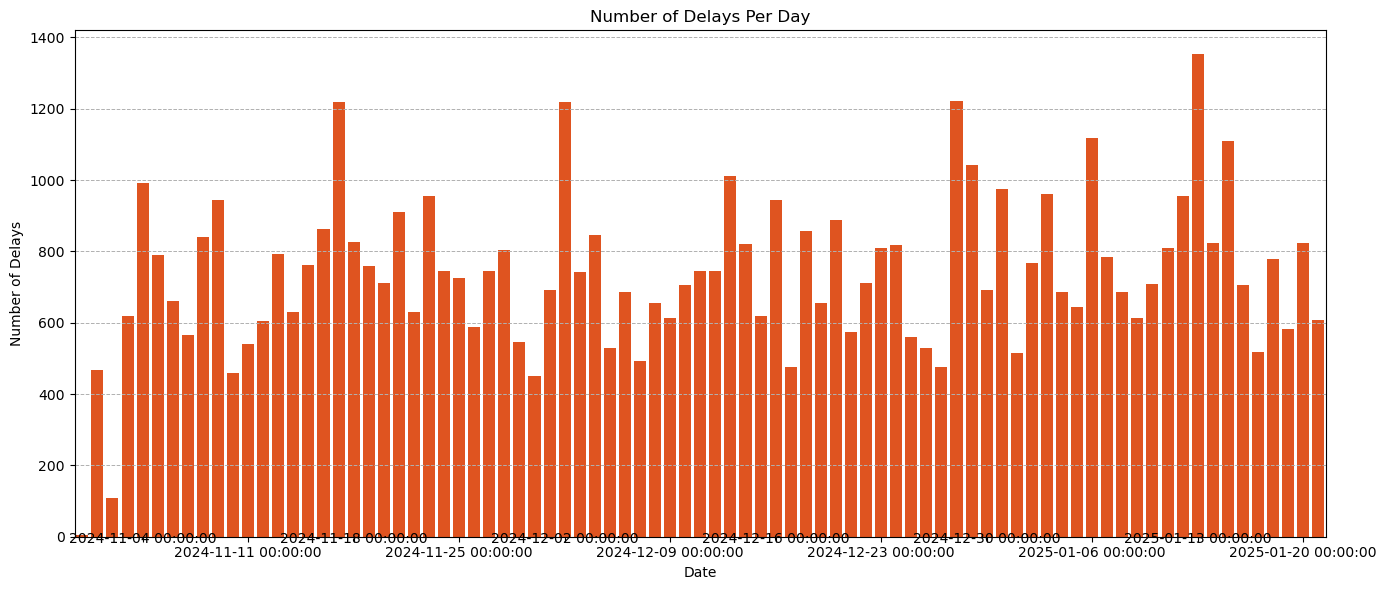

In [108]:
## idk how to format the dates propertly and on axis ticker location

# Ensure the datetime column is in proper format
merged_metro['nearest_datetime'] = pd.to_datetime(merged_metro['nearest_datetime'])

# Filter for delayed departures
delayed_metro = merged_metro[merged_metro['departure_status'] == 'delayed']

# Group by date and count the number of delays
delayed_count_per_day = delayed_metro.groupby(delayed_metro['nearest_datetime'].dt.date).size().reset_index(name='delay_count')

# Rename columns for clarity
delayed_count_per_day.rename(columns={'nearest_datetime': 'date'}, inplace=True)

# Convert 'date' to datetime for better handling of date ticks
delayed_count_per_day['date'] = pd.to_datetime(delayed_count_per_day['date'])

# Plot as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=delayed_count_per_day,
    x='date',
    y='delay_count',
    color="#FF4500"  # Custom orange-red color
)

# Set x-axis ticks to be on each Monday
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # Major ticks every Monday

# Get the current axis and set the ticks
ax = plt.gca()
ticks = ax.get_xticks()

# Alternate the height of the ticks
for i, tick in enumerate(ticks):
    if i % 2 == 0:
        ax.get_xticklabels()[i].set_verticalalignment('bottom')  # Lower even-index ticks
    else:
        ax.get_xticklabels()[i].set_verticalalignment('top')  # Raise odd-index ticks

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Delays')
plt.title('Number of Delays Per Day')

# Enable grid for better visibility of bar heights
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Delays-Per-Day-Weekly-Ticks-Alternating.png", format='png', dpi=300)
plt.show()


In [156]:
metro_line_palette = {
    'C01371': '#FFCE00',
    'C01372': '#0064B0',
    'C01373': '#9F9825',
    'C01374': '#C04191',
    'C01375': '#F28E42',
    'C01376': '#83C491',
    'C01377': '#F3A4BA',
    'C01378': '#CEADD2',
    'C01379': '#D5C900',
    'C01380': '#E3B32A',
    'C01381': '#8D5E2A',
    'C01382': '#00814F',
    'C01383': '#98D4E2',
    'C01384': '#662483',
    'C01386': '#98D4E2',
    'C01387': '#83C491'
}

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

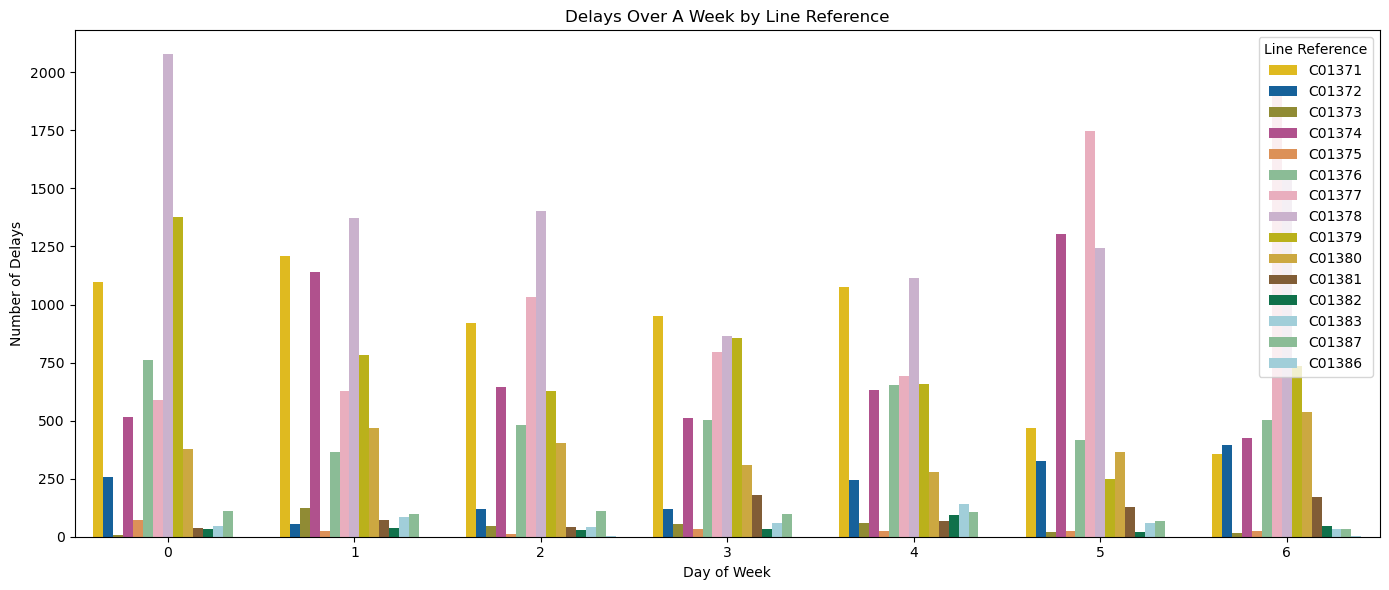

In [158]:
delayed_daily_summary = (
    delayed_metro.groupby(['day_of_week', 'line_ref']) #0 is monday
    .size()
    .reset_index(name='delay_count')
)

# Set up the plot
plt.figure(figsize=(14, 6))

# Bar plot grouped by day_of_month with color-coded line_ref
sns.barplot(
    data=delayed_daily_summary,
    x='day_of_week',
    y='delay_count',
    hue='line_ref',  # Color separation by line_ref
    palette=metro_line_palette
)

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('Number of Delays')
plt.title('Delays Over A Week by Line Reference')

# Adjust ticks for better readability

# Enable legend
plt.legend(title='Line Reference', loc='upper right')

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Delays-Week-Days-By-Line.png", format='png', dpi=300)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

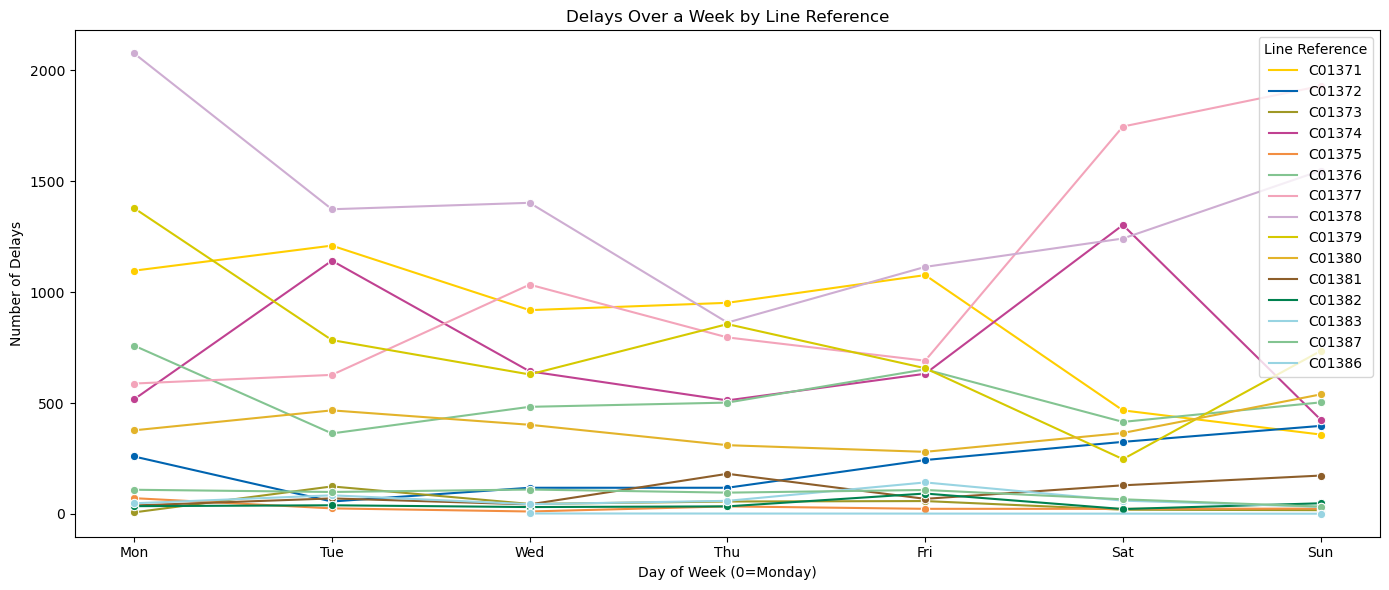

In [159]:
# same thing but line plot

# Group by day_of_week and line_ref
delayed_daily_summary = (
    delayed_metro.groupby(['day_of_week', 'line_ref'])  # 0 is Monday
    .size()
    .reset_index(name='delay_count')
)

# Set up the plot
plt.figure(figsize=(14, 6))

# Line plot with scatter points
sns.lineplot(
    data=delayed_daily_summary,
    x='day_of_week',
    y='delay_count',
    hue='line_ref',  # Color separation by line_ref
    marker='o',  # Add scatter points
    palette=metro_line_palette
)

# Add labels and title
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Number of Delays')
plt.title('Delays Over a Week by Line Reference')

# Set x-ticks to represent days of the week (0=Monday, 6=Sunday)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Enable legend
plt.legend(title='Line Reference', loc='upper right')

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Delays-Week-Days-Line-Scatter.png", format='png', dpi=300)
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

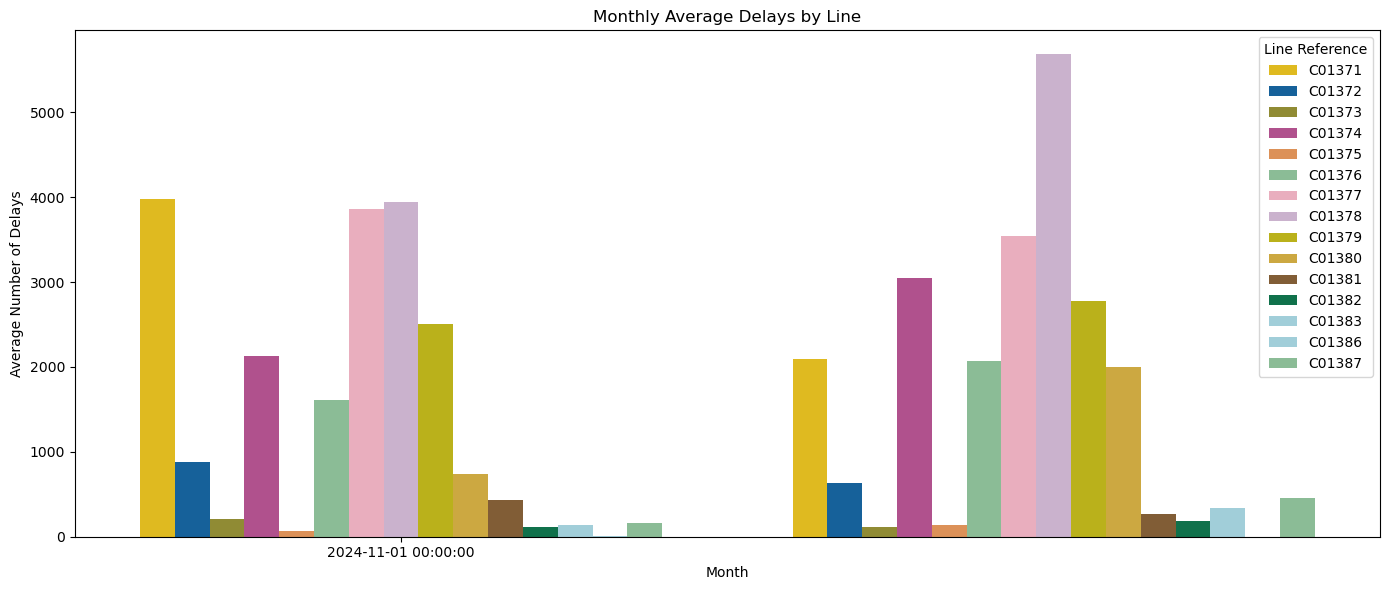

In [161]:
merged_metro['nearest_datetime'] = pd.to_datetime(merged_metro['nearest_datetime'])

delayed_metro = merged_metro[merged_metro['departure_status'] == 'delayed']

start_date = pd.to_datetime('2024-11-02 00:00:00')
end_date = pd.to_datetime('2024-12-31 23:59:59')

delayed_metro = delayed_metro[(delayed_metro['nearest_datetime'] >= start_date) & (delayed_metro['nearest_datetime'] <= end_date)]


# Extract month and year for grouping
delayed_metro['year_month'] = delayed_metro['nearest_datetime'].dt.to_period('M')

# Group by 'year_month' and 'line_ref' and count delays
monthly_avg_delays = (
    delayed_metro.groupby(['year_month', 'line_ref'])
    .size()
    .reset_index(name='delay_count')
)


# Convert 'year_month' back to datetime for plotting
monthly_avg_delays['year_month'] = monthly_avg_delays['year_month'].dt.to_timestamp()

# Set up the plot
plt.figure(figsize=(14, 6))

# Create the bar plot with color separation by 'line_ref'
sns.barplot(
    data=monthly_avg_delays,
    x='year_month',
    y='delay_count',
    hue='line_ref',  # Color separation by line_ref
    palette=metro_line_palette  # Seaborn palette for color separation
)

# Format the x-axis for better date handling
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to months
## add proper novermber december tickers!!


# Add labels and title
plt.xlabel('Month')
plt.ylabel('Average Number of Delays')
plt.title('Monthly Average Delays by Line')

# Enable legend
plt.legend(title='Line Reference', loc='upper right')

# Tight layout for better spacing
plt.tight_layout()

# Save and display the plot
plt.savefig("./Figures/Monthly-Delays-By-Line.png", format='png', dpi=300)
plt.show()

## all rer

In [164]:
#same stuff here but with delay time too ig

## individual 8 stops

In [87]:
APK = pd.read_csv("./Stations/APK.csv")
GBG = pd.read_csv("./Stations/GBG.csv")
CLH = pd.read_csv("./Stations/CLH.csv", low_memory=False)
MP = pd.read_csv("./Stations/MP.csv")

CDG = pd.read_csv("./Stations/CDG.csv")
SL = pd.read_csv("./Stations/SL.csv")
SGP = pd.read_csv("./Stations/SGP.csv")
BL = pd.read_csv("./Stations/BL.csv")

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will

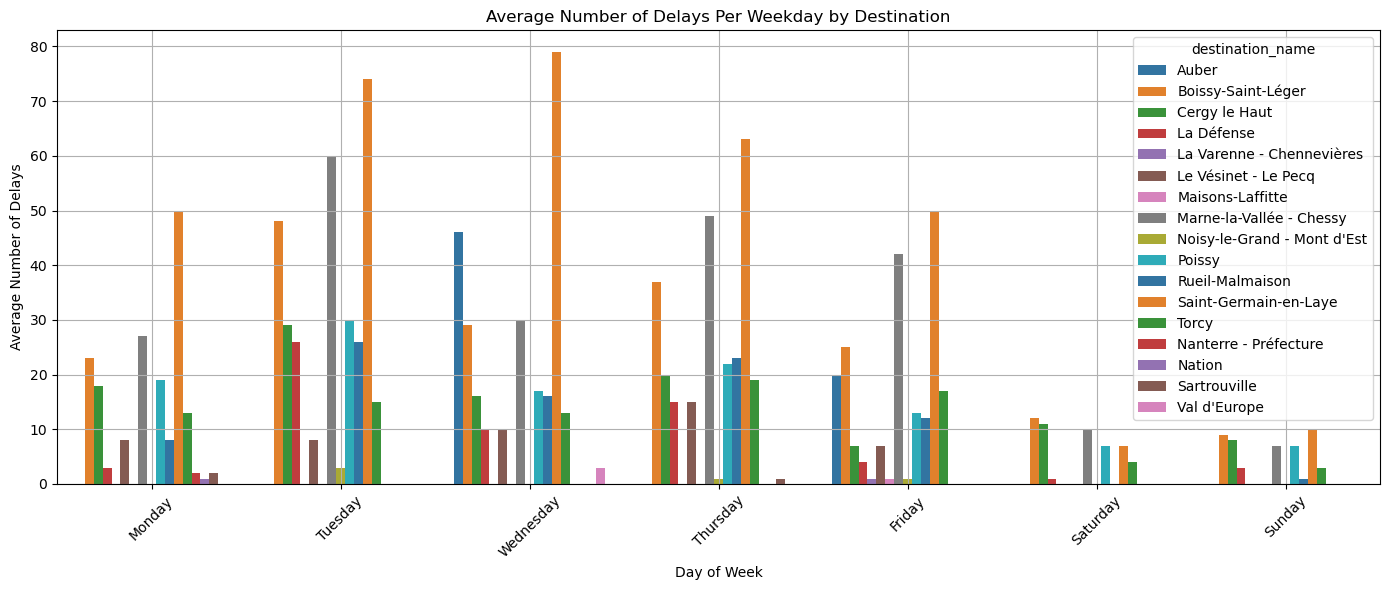

In [99]:
## for better readability, merge noth/south east/west directions

# Ensure the datetime column is in the correct format (if not already)
CLH['scheduled_arrival'] = pd.to_datetime(CLH['scheduled_arrival'])

# Filter for delayed departures
delayed_rer = CLH[CLH['departure_status'] == 'delayed']

# Add a 'day_of_week' column (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) using .loc
delayed_rer.loc[:, 'day_of_week'] = delayed_rer['scheduled_arrival'].dt.dayofweek

# Map numerical days to actual weekday names using .loc
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
delayed_rer.loc[:, 'day_of_week'] = delayed_rer['day_of_week'].map(day_names)

# Group by day of the week and destination_name, then count the number of delays
delayed_count_per_weekday = delayed_rer.groupby(['day_of_week', 'destination_name']).size().reset_index(name='delay_count')

# Calculate the average number of delays per weekday for each destination
average_delays_per_weekday = delayed_count_per_weekday.groupby(['day_of_week', 'destination_name'])['delay_count'].mean().reset_index()

# Sort by weekday order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_delays_per_weekday['day_of_week'] = pd.Categorical(average_delays_per_weekday['day_of_week'], categories=ordered_days, ordered=True)

# Plot the average delays per weekday for each destination as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=average_delays_per_weekday,
    x='day_of_week',
    y='delay_count',
    hue='destination_name',
    palette = "tab10"
)

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Delays')
plt.title('Average Number of Delays Per Weekday by Destination')

# Rotate x-ticks for better readability
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [89]:
rer_stops["stop_name"].value_counts()

stop_name
Châtelet - Les Halles          42906
Avenue du Président Kennedy    10896
Massy - Palaiseau               7438
Gare de Buno Gironville         3959
Name: count, dtype: int64

## rer (4 stops)

In [ ]:
rer_stops = pd.concat([APK, GBG, CLH, MP], ignore_index=True)


In [ ]:
# Ensure datetime format
rer_filtered = rer_stops[rer_stops['arrival_difference'] <= 100].copy()
rer_filtered['hour'] = rer_filtered['scheduled_arrival'].dt.hour

# Group by 'hour' and 'ArRTown' to calculate mean delay
average_delay_by_category = rer_filtered.groupby(['hour', 'stop_name'])['arrival_difference'].mean().reset_index()

custom_palette = {
    'Massy - Palaiseau': '#4B92DB',
    'Avenue du Président Kennedy': '#F3D311',
    'Châtelet - Les Halles': '#F7403A',
    'Gare de Buno Gironville': '#3F9C35'
}

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=average_delay_by_category,
    x='hour',
    y='arrival_difference',
    hue='stop_name',
    palette=custom_palette,
    marker="o"
)

#plt.xticks(ticks=range(0, 24), labels=[str(hour) for hour in range(24)])
plt.gca().set_xticks(range(0, 24, 4))  # Major ticks every 4 hours

plt.xlabel('Hour of the Day')
plt.ylabel('Average Delay (in mins)')
plt.title('Average Delay Duration Over a Single Day by Stop')
plt.legend(title="stop_name")
plt.grid(True)
plt.savefig("./Figures/Average-Delay-Stop.png", format='png', dpi=300)
plt.show()


In [ ]:
# Remove outliers where delay exceeds 100 seconds
rer_filtered = rer_stops[rer_stops['arrival_difference'] <= 100]

rer_filtered.loc[:, 'day_of_week'] = rer_filtered['scheduled_arrival'].dt.dayofweek
rer_filtered.loc[:, 'day_of_week'] = rer_filtered['day_of_week'].map(day_names)
rer_filtered.loc[:, 'day_of_week'] = pd.Categorical(
    rer_filtered['day_of_week'],
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)

# Group by 'day_of_week' and 'ArRTown' to calculate mean delay
average_delay_by_day = rer_filtered.groupby(
    ['day_of_week', 'stop_name'], observed=False
)['arrival_difference'].mean().reset_index()


custom_palette = {
    'Massy - Palaiseau': '#4B92DB',
    'Avenue du Président Kennedy': '#F3D311',
    'Châtelet - Les Halles': '#F7403A',
    'Gare de Buno Gironville': '#3F9C35'
}

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=average_delay_by_day,
    x='day_of_week',
    y='arrival_difference',
    hue='stop_name',
    palette=custom_palette,
    marker="o"
)
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (in secs)')
plt.title('Average Delay Duration by Day of the Week and Stop (Filtered)')
plt.legend(title="stop_name")
plt.grid(True)
plt.savefig("./Figures/Average-Delay-DayOfWeek-Stop.png", format='png', dpi=300)
plt.show()


In [ ]:
## idk how to format the dates propertly and on axis ticker location

# Ensure the datetime column is in proper format
rer_stops['Date'] = pd.to_datetime(rer_stops['Date'])

# Filter for delayed departures
#delayed_rer = rer[rer['departure_status'] == 'delayed']

# Group by date and count the number of delays
#delayed_count_per_day = delayed_rer.groupby(delayed_rer['Date'].dt.date).size().reset_index(name='delay_count')
average_delay_by_category = rer_filtered.groupby(['Date', 'stop_name'])['arrival_difference'].mean().reset_index()

# Rename columns for clarity
average_delay_by_category.rename(columns={'Date': 'date'}, inplace=True)

# Convert 'date' to datetime for better handling of date ticks
average_delay_by_category['date'] = pd.to_datetime(average_delay_by_category['date'])

# Plot as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=average_delay_by_category,
    x='date',
    y='arrival_difference',
    color="#FF4500"  # Custom orange-red color
)

# Set x-axis ticks to be on each Monday
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # Major ticks every Monday

# Get the current axis and set the ticks
ax = plt.gca()
ticks = ax.get_xticks()

# Alternate the height of the ticks
for i, tick in enumerate(ticks):
    if i % 2 == 0:
        ax.get_xticklabels()[i].set_verticalalignment('bottom')  # Lower even-index ticks
    else:
        ax.get_xticklabels()[i].set_verticalalignment('top')  # Raise odd-index ticks

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Duration of Delays')
plt.title('Duration of Delays Per Day')

# Enable grid for better visibility of bar heights
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Duration-Delays-Per-Day-Weekly-Ticks-Alternating.png", format='png', dpi=300)
plt.show()


In [ ]:
## idk how to format the dates propertly and on axis ticker location

# Ensure the datetime column is in proper format
rer_stops['Date'] = pd.to_datetime(rer['Date'])

# Filter for delayed departures
delayed_rer = rer_stops[rer_stops['departure_status'] == 'delayed']

# Group by date and count the number of delays
delayed_count_per_day = delayed_rer.groupby(delayed_rer['Date'].dt.date).size().reset_index(name='delay_count')

# Rename columns for clarity
delayed_count_per_day.rename(columns={'Date': 'date'}, inplace=True)

# Convert 'date' to datetime for better handling of date ticks
delayed_count_per_day['date'] = pd.to_datetime(delayed_count_per_day['date'])

# Plot as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=delayed_count_per_day,
    x='date',
    y='delay_count',
    color="#FF4500"  # Custom orange-red color
)

# Set x-axis ticks to be on each Monday
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # Major ticks every Monday

# Get the current axis and set the ticks
ax = plt.gca()
ticks = ax.get_xticks()

# Alternate the height of the ticks
for i, tick in enumerate(ticks):
    if i % 2 == 0:
        ax.get_xticklabels()[i].set_verticalalignment('bottom')  # Lower even-index ticks
    else:
        ax.get_xticklabels()[i].set_verticalalignment('top')  # Raise odd-index ticks

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Delays')
plt.title('Number of Delays Per Day')

# Enable grid for better visibility of bar heights
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Delays-Per-Day-Weekly-Ticks-Alternating.png", format='png', dpi=300)
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

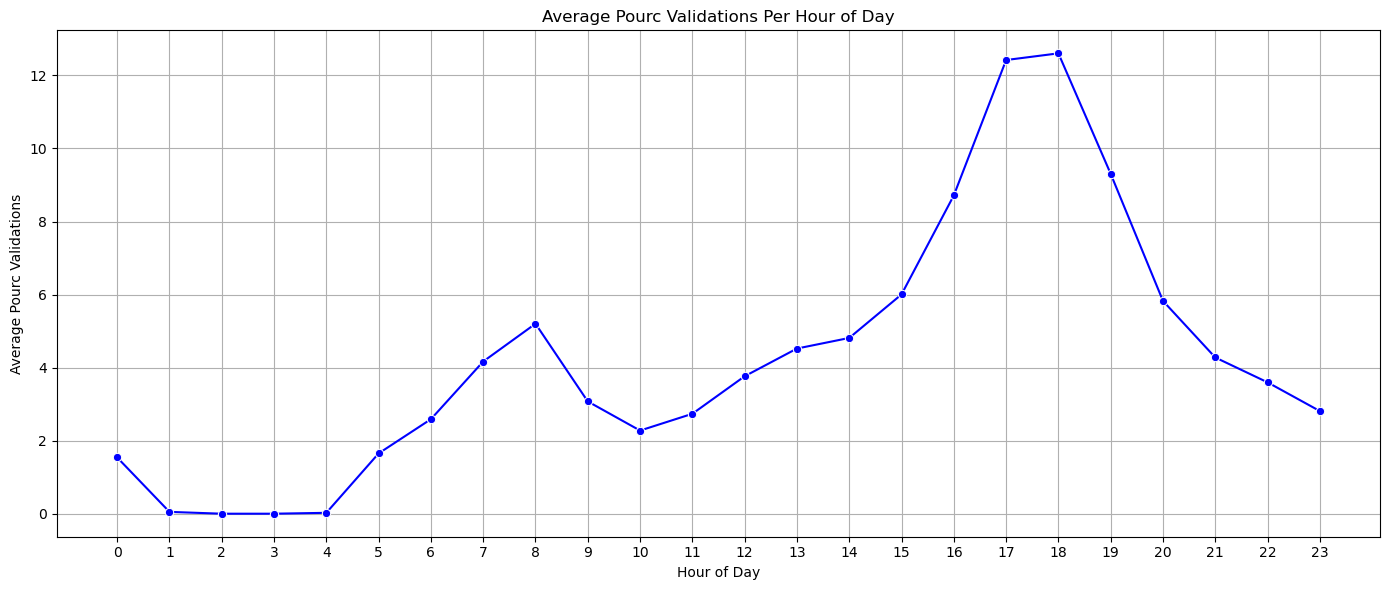

In [91]:
# Ensure the datetime column is in the correct format (if not already)
rer_stops['scheduled_arrival'] = pd.to_datetime(rer_stops['scheduled_arrival'])

# Extract hour from the datetime column
rer_stops['hour'] = rer_stops['scheduled_arrival'].dt.hour

# Group by hour and calculate the average pourc_validations
hourly_validations = rer_stops.groupby('hour')['pourc_validations'].mean().reset_index()

# Plot the hourly average pourc_validations
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=hourly_validations,
    x='hour',
    y='pourc_validations',
    marker='o',
    color='b'  # Blue color for the line
)

# Add labels and title
plt.xlabel('Hour of Day')
plt.ylabel('Average Pourc Validations')
plt.title('Average Pourc Validations Per Hour of Day')

# Set the x-ticks to be from 0 to 23 (representing hours)
plt.xticks(range(24))

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


## metro (4 stops)

In [ ]:
metro_stops = pd.concat([CDG, SL, SGP, BL], ignore_index=True)

In [ ]:
## for better readability, merge noth/south east/west directions

# Ensure the datetime column is in the correct format (if not already)
metro_stops['real_arrival'] = pd.to_datetime(metro_stops['real_arrival'])

# Filter for delayed departures
delayed_rer = metro_stops[metro_stops['departure_status'] == 'delayed']

# Add a 'day_of_week' column (0 = Monday, 1 = Tuesday, ..., 6 = Sunday) using .loc
delayed_rer.loc[:, 'day_of_week'] = delayed_rer['real_arrival'].dt.dayofweek

# Map numerical days to actual weekday names using .loc
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
delayed_rer.loc[:, 'day_of_week'] = delayed_rer['day_of_week'].map(day_names)

# Group by day of the week and destination_name, then count the number of delays
delayed_count_per_weekday = delayed_rer.groupby(['day_of_week', 'destination_name']).size().reset_index(name='delay_count')

# Calculate the average number of delays per weekday for each destination
average_delays_per_weekday = delayed_count_per_weekday.groupby(['day_of_week', 'destination_name'])['delay_count'].mean().reset_index()

# Sort by weekday order
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_delays_per_weekday['day_of_week'] = pd.Categorical(average_delays_per_weekday['day_of_week'], categories=ordered_days, ordered=True)

# Plot the average delays per weekday for each destination as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=average_delays_per_weekday,
    x='day_of_week',
    y='delay_count',
    hue='destination_name',
    palette = "tab10"
)

# Add labels and title
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Delays')
plt.title('Average Number of Delays Per Weekday by Destination')

# Rotate x-ticks for better readability
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
## idk how to format the dates propertly and on axis ticker location

# Ensure the datetime column is in proper format
metro_stops['real_arrival'] = pd.to_datetime(metro_stops['real_arrival'])

# Filter for delayed departures
delayed_metro = metro_stops[metro_stops['departure_status'] == 'delayed']

# Group by date and count the number of delays
delayed_count_per_day = delayed_metro.groupby(delayed_metro['real_arrival'].dt.date).size().reset_index(name='delay_count')

# Rename columns for clarity
delayed_count_per_day.rename(columns={'real_arrival': 'date'}, inplace=True)

# Convert 'date' to datetime for better handling of date ticks
delayed_count_per_day['date'] = pd.to_datetime(delayed_count_per_day['date'])

# Plot as a bar chart
plt.figure(figsize=(14, 6))
sns.barplot(
    data=delayed_count_per_day,
    x='date',
    y='delay_count',
    color="#FF4500"  # Custom orange-red color
)

# Set x-axis ticks to be on each Monday
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))  # Major ticks every Monday

# Get the current axis and set the ticks
ax = plt.gca()
ticks = ax.get_xticks()

# Alternate the height of the ticks
for i, tick in enumerate(ticks):
    if i % 2 == 0:
        ax.get_xticklabels()[i].set_verticalalignment('bottom')  # Lower even-index ticks
    else:
        ax.get_xticklabels()[i].set_verticalalignment('top')  # Raise odd-index ticks

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Delays')
plt.title('Number of Delays Per Day')

# Enable grid for better visibility of bar heights
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig("./Figures/Delays-Per-Day-Weekly-Ticks-Alternating.png", format='png', dpi=300)
plt.show()


In [ ]:
# Ensure the datetime column is in the correct format (if not already)
metro_stops['real_arrival'] = pd.to_datetime(metro_stops['real_arrival'])

# Extract hour from the datetime column
metro_stops['hour'] = metro_stops['real_arrival'].dt.hour

# Group by hour and calculate the average pourc_validations
hourly_validations = metro.groupby('hour')['pourc_validations'].mean().reset_index()

# Plot the hourly average pourc_validations
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=hourly_validations,
    x='hour',
    y='pourc_validations',
    marker='o',
    color='b'  # Blue color for the line
)

# Add labels and title
plt.xlabel('Hour of Day')
plt.ylabel('Average Pourc Validations')
plt.title('Average Pourc Validations Per Hour of Day')

# Set the x-ticks to be from 0 to 23 (representing hours)
plt.xticks(range(24))

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
